## IMPORTS

In [449]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv("House_Rent_Dataset.csv")

In [450]:
data.head(20)

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner
5,2022-04-29,2,7000,600,Ground out of 1,Super Area,Thakurpukur,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
6,2022-06-21,2,10000,700,Ground out of 4,Super Area,Malancha,Kolkata,Unfurnished,Bachelors,2,Contact Agent
7,2022-06-21,1,5000,250,1 out of 2,Super Area,Malancha,Kolkata,Unfurnished,Bachelors,1,Contact Agent
8,2022-06-07,2,26000,800,1 out of 2,Carpet Area,"Palm Avenue Kolkata, Ballygunge",Kolkata,Unfurnished,Bachelors,2,Contact Agent
9,2022-06-20,2,10000,1000,1 out of 3,Carpet Area,Natunhat,Kolkata,Semi-Furnished,Bachelors/Family,2,Contact Owner


### Exploratory Data Analysis

In [451]:
data['Tenant Preferred'].unique()

array(['Bachelors/Family', 'Bachelors', 'Family'], dtype=object)

In [452]:
data['Area Type'].unique()

array(['Super Area', 'Carpet Area', 'Built Area'], dtype=object)

In [453]:
data[data['Floor'] == 'Ground'].shape[0]


1

In [454]:
data['Bathroom'].unique()

array([ 2,  1,  3,  5,  4,  6,  7, 10], dtype=int64)

<Axes: xlabel='Bathroom', ylabel='Rent'>

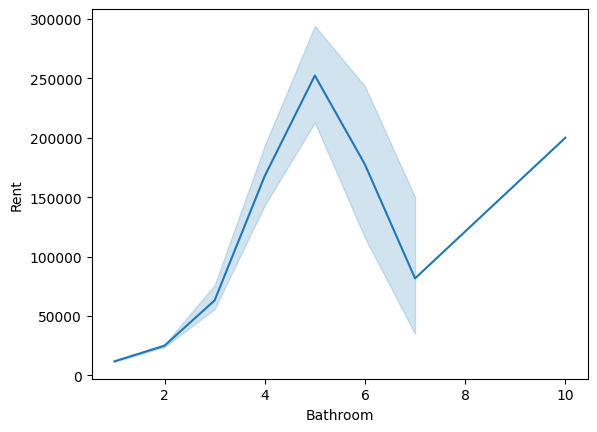

In [455]:
sns.lineplot(x='Bathroom', y='Rent', data=data)

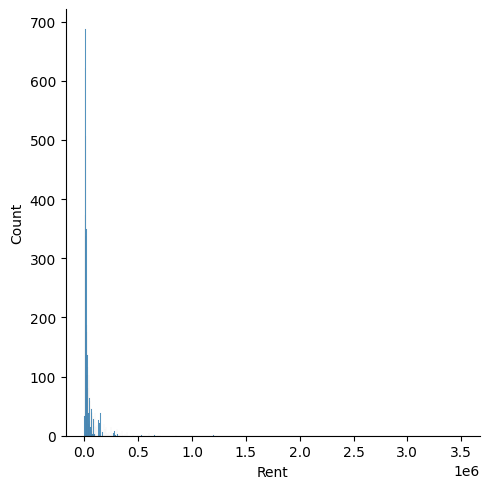

In [456]:
sns.displot(data['Rent'])

## Preprocessing

### Data Cleaning

In [457]:
data = data[['BHK',
             'Bathroom',
             'Furnishing Status',
             'Rent',
             'Size',
             'Floor',
             'Area Type',
             'Tenant Preferred',
             'Point of Contact',
             #'Area Locality',
             'City'
             ]]

#### Removing Rent Outliers

In [458]:
def remove_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data = data[ (data[column] >= lower_bound) & (data[column] <= upper_bound)]
    return data

data = remove_outliers(data, 'Rent')
data = remove_outliers(data, 'BHK')
#data = remove_outliers(data, 'Bathroom')
#data = remove_outliers(data, 'Size')

### Addressing Floor Column

In [459]:


data[['CurrentFloor', 'TotalFloors']] = data['Floor'].str.split(' out of ', expand=True)

data['CurrentFloor'] = data['CurrentFloor'].replace("Ground", 1)
data['CurrentFloor'] = data['CurrentFloor'].replace("Upper Basement", 0)
data['CurrentFloor'] = data['CurrentFloor'].replace("Lower Basement", -1)

data['CurrentFloor'] = pd.to_numeric(data['CurrentFloor'])
data['TotalFloors'] = pd.to_numeric(data['TotalFloors'])
data['CurrentFloor'] = data['CurrentFloor'] + 2
data['TotalFloors'] = data['TotalFloors'] + 2

data.dropna(inplace=True)


data.drop('Floor', axis=1, inplace=True)


In [460]:
data.head()

,BHK,Bathroom,Furnishing Status,Rent,Size,Area Type,Tenant Preferred,Point of Contact,City,CurrentFloor,TotalFloors
0,2,2,Unfurnished,10000,1100,Super Area,Bachelors/Family,Contact Owner,Kolkata,3,4.0
1,2,1,Semi-Furnished,20000,800,Super Area,Bachelors/Family,Contact Owner,Kolkata,3,5.0
2,2,1,Semi-Furnished,17000,1000,Super Area,Bachelors/Family,Contact Owner,Kolkata,3,5.0
3,2,1,Unfurnished,10000,800,Super Area,Bachelors/Family,Contact Owner,Kolkata,3,4.0
4,2,1,Unfurnished,7500,850,Carpet Area,Bachelors,Contact Owner,Kolkata,3,4.0


### Encoding

In [461]:
def one_hot_encode(data, column):
    encoded = pd.get_dummies(data[column], drop_first= True)
    data = data.drop(column, axis = 1)
    data = data.join(encoded)
    return data

data = one_hot_encode(data, 'Furnishing Status')
data = one_hot_encode(data, 'Tenant Preferred')
data = one_hot_encode(data, 'Point of Contact')
data = one_hot_encode(data, 'Area Type')
data = one_hot_encode(data, 'City')

### Train/Test Splitting

In [462]:
X = data.drop('Rent', axis= 1)
y = data['Rent']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.33 , random_state = 42)

### Standardization

In [463]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [464]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
X_train = poly.fit_transform(X_train)
X_test = poly.transform(X_test)


In [465]:
data

,BHK,Bathroom,Rent,Size,CurrentFloor,TotalFloors,Semi-Furnished,Unfurnished,Bachelors/Family,Family,Contact Builder,Contact Owner,Carpet Area,Super Area,Chennai,Delhi,Hyderabad,Kolkata,Mumbai
0,2,2,10000,1100,3,4.0,False,True,True,False,False,True,False,True,False,False,False,True,False
1,2,1,20000,800,3,5.0,True,False,True,False,False,True,False,True,False,False,False,True,False
2,2,1,17000,1000,3,5.0,True,False,True,False,False,True,False,True,False,False,False,True,False
3,2,1,10000,800,3,4.0,False,True,True,False,False,True,False,True,False,False,False,True,False
4,2,1,7500,850,3,4.0,False,True,False,False,False,True,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4741,2,2,15000,1000,5,7.0,True,False,True,False,False,True,True,False,False,False,True,False,False
4742,3,3,29000,2000,3,6.0,True,False,True,False,False,True,False,True,False,False,True,False,False
4743,3,3,35000,1750,5,7.0,True,False,True,False,False,False,True,False,False,False,True,False,False
4744,3,2,45000,1500,25,36.0,True,False,False,True,False,False,True,False,False,False,True,False,False


## Modelling

In [466]:
from sklearn import linear_model
from sklearn.linear_model import RidgeCV
model = linear_model.LinearRegression()
model = RidgeCV(alphas=[ 0.1, 1, 10])
model.fit(X_train, y_train)
model.coef_

array([ 0.00000000e+00,  1.79715521e+03,  1.21383160e+03,  5.10032990e+03,
        1.85199687e+02,  1.07461274e+03, -4.99301815e+02, -7.78008492e+02,
       -2.06223475e+02, -3.74453219e+01, -7.50182958e-02, -1.18160193e+03,
        1.77756313e+02, -5.15381515e+01, -1.67635834e+02,  1.16517253e+02,
       -2.57899850e+02, -2.30635682e+02,  1.31555652e+03, -2.29779439e+02,
        1.16190144e+03,  2.64174091e+02,  8.22579591e+02, -1.48056869e+03,
        7.35661119e+02,  1.00699889e+03, -5.56397478e+02, -6.92878211e+02,
       -3.39707701e+01,  1.55815660e+02,  5.25980980e+01, -3.80119307e+01,
       -1.25613830e+02,  8.88994921e+01, -4.23099006e+02, -3.92794332e+02,
        6.15833632e+01, -6.09645850e+02, -9.47375616e+01, -6.08585018e+02,
        6.63464136e+00, -2.82066545e+02, -7.03178536e+01,  4.68536980e+02,
        3.23521501e+02, -2.29236064e+01, -4.49358291e+02,  2.76291184e+02,
       -2.35468108e+02,  2.06585646e+02,  9.39729154e+02,  3.81330145e+02,
       -9.01160968e+00,  

In [467]:
# from sklearn.linear_model import RidgeCV

# model = RidgeCV()
# model.fit(X_train, y_train)


# Evaluation

In [468]:
y_preds = model.predict(X_test)

In [469]:
from sklearn.metrics import mean_squared_error, r2_score

# The coefficients
print("Coefficients: \n", model.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_preds))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_preds))

Coefficients: 
 [ 0.00000000e+00  1.79715521e+03  1.21383160e+03  5.10032990e+03
  1.85199687e+02  1.07461274e+03 -4.99301815e+02 -7.78008492e+02
 -2.06223475e+02 -3.74453219e+01 -7.50182958e-02 -1.18160193e+03
  1.77756313e+02 -5.15381515e+01 -1.67635834e+02  1.16517253e+02
 -2.57899850e+02 -2.30635682e+02  1.31555652e+03 -2.29779439e+02
  1.16190144e+03  2.64174091e+02  8.22579591e+02 -1.48056869e+03
  7.35661119e+02  1.00699889e+03 -5.56397478e+02 -6.92878211e+02
 -3.39707701e+01  1.55815660e+02  5.25980980e+01 -3.80119307e+01
 -1.25613830e+02  8.88994921e+01 -4.23099006e+02 -3.92794332e+02
  6.15833632e+01 -6.09645850e+02 -9.47375616e+01 -6.08585018e+02
  6.63464136e+00 -2.82066545e+02 -7.03178536e+01  4.68536980e+02
  3.23521501e+02 -2.29236064e+01 -4.49358291e+02  2.76291184e+02
 -2.35468108e+02  2.06585646e+02  9.39729154e+02  3.81330145e+02
 -9.01160968e+00  7.76986362e+01  4.63471231e+02 -7.56056115e+02
  1.50918373e+03 -1.02209810e+03 -1.54670984e+03  5.24155392e+01
  2.71723

In [470]:
train_r2 = model.score(X_train, y_train)
print("Training Coefficient of Determination: %.2f" % train_r2)


Training Coefficient of Determination: 0.76


### Qualitative Evaluation

In [471]:
sample_data = X.iloc[0]
sample_data

BHK                     2
Bathroom                2
Size                 1100
CurrentFloor            3
TotalFloors           4.0
Semi-Furnished      False
Unfurnished          True
Bachelors/Family     True
Family              False
Contact Builder     False
Contact Owner        True
Carpet Area         False
Super Area           True
Chennai             False
Delhi               False
Hyderabad           False
Kolkata              True
Mumbai              False
Name: 0, dtype: object

In [472]:
sample_data_standardized = poly.transform(X.iloc[0].values.reshape(1,-1))

In [473]:
model_rent_forecast = model.predict(sample_data_standardized)[0]
model_rent_forecast

568663263.6648724

In [474]:
y.iloc[0]

10000

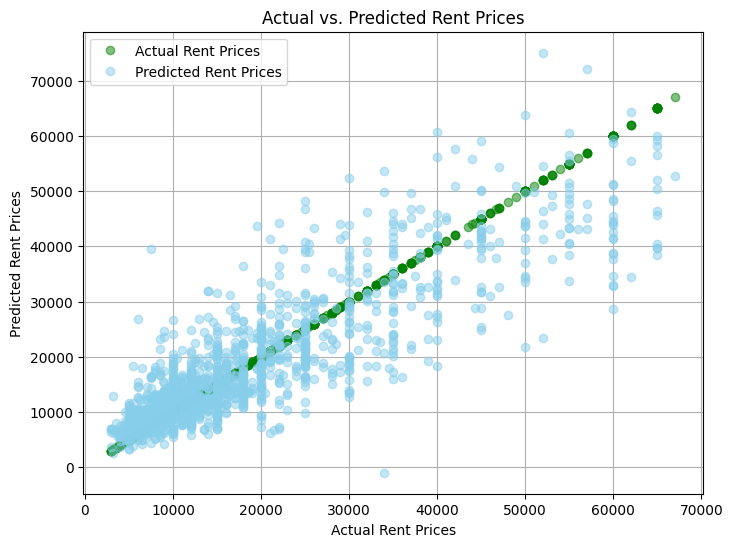

In [475]:
plt.figure(figsize=(8,6))
plt.plot(y_test, y_test, 'o', alpha=0.5, color='green', label='Actual Rent Prices')
plt.plot(y_test, y_preds, 'o', alpha=0.5, color='skyblue', label='Predicted Rent Prices')

plt.title("Actual vs. Predicted Rent Prices")
plt.xlabel("Actual Rent Prices")
plt.ylabel("Predicted Rent Prices")

plt.legend()
plt.grid(True)
plt.show()